# Enoncé

- Rajoute un modèle d'apprentissage basé sur les polynôme trigonométriques.
C'est à dire passer des fonctions
$$
P(x)=\sum_{k=0}^d c_k x^k
$$
aux fonctions
$$
T(x)= c_0 + \sum_{k=1}^d c_k \cos\left(2k\pi \frac{x-a}{b-a}\right) + \sum_{k=1}^d c_{d+k} \sin\left(2k\pi \frac{x-a}{b-a}\right)
$$
où la cible est $f:[a,b] \mapsto \mathbb{R}$.
- Coder une fonction `train_test_split` permettant de découper un échantillon en deux: une partie pour l'entrainement, une partie pour détecter un éventuel surapprentissage.
- Coder une fonction `cross_validation` qui permet de sélectionner un meilleur modèle à partir de la partie entrainement de l'échantillon.

# Mise en place

In [1]:
import lib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

In [3]:
cible = lib.Cible(
    fonction=lambda x: np.exp(1. / (2. + np.sin(5 * x) * np.cos(20 * x))),
    gauche=0.,
    droite=1.,
)

In [4]:
echantillon = lib.genere_echantillon(
    cible=cible, 
    nb_points=50, 
    choix_points=lib.ChoixPoints.uniforme, 
    choix_bruit=lib.ChoixBruit.normale, 
    amplitude=0.1
)

# Comparaison des deux types de modèles

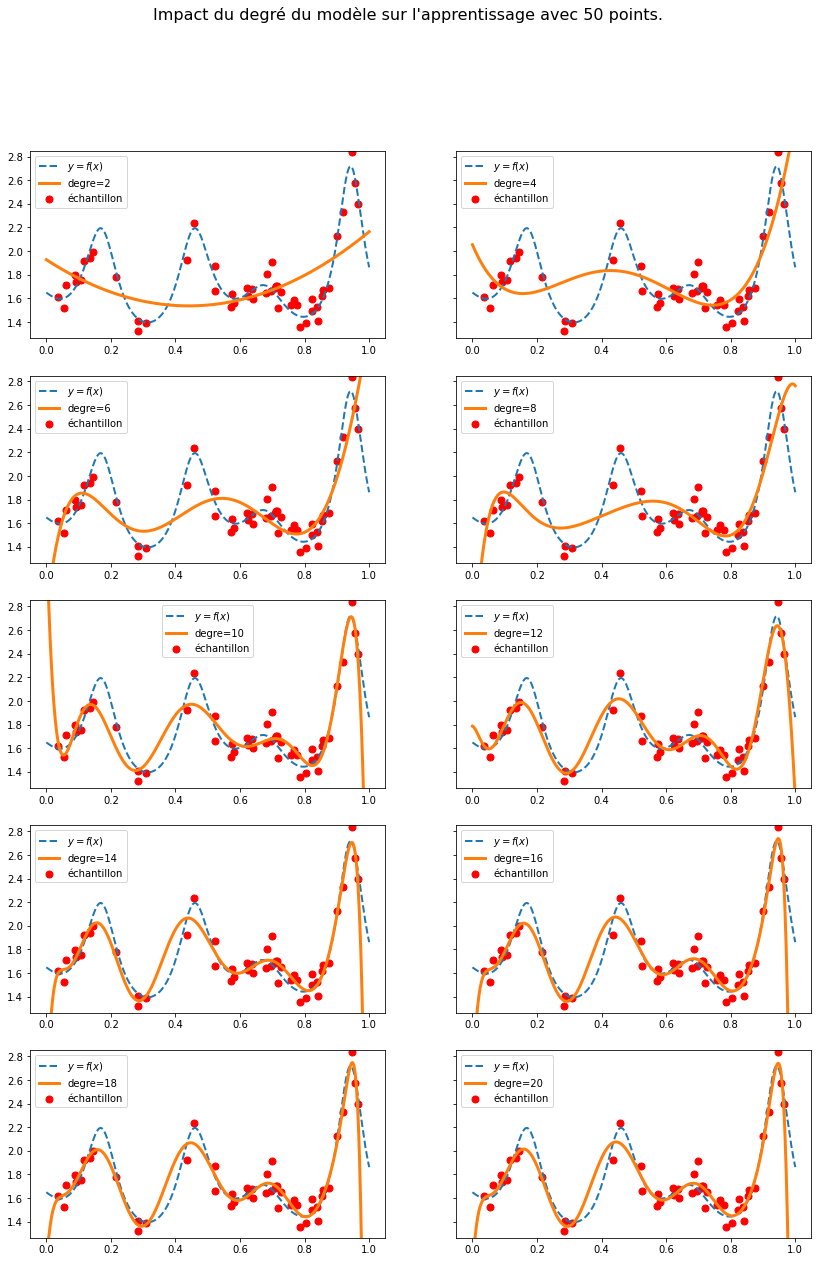

In [5]:
degres = [2 * d for d in range(1, 11)]
fig, reps = plt.subplots(nrows=5, ncols=2, sharey=True, figsize=(14, 20))

fig.suptitle(
    "Impact du degré du modèle sur l'apprentissage avec " 
    f"{len(echantillon.abcisses)} points.",
    fontsize=16
)
for degre, rep in zip(degres, reps.flatten()):
    cible.affichage(rep)
    echantillon.affichage(rep)
    modele = lib.ModelePolynomial(degre)
    modele.entraine(echantillon)
    modele.affichage(cible=cible, repere=rep)
    rep.set_ylim(cible.min, cible.max)
    rep.legend()

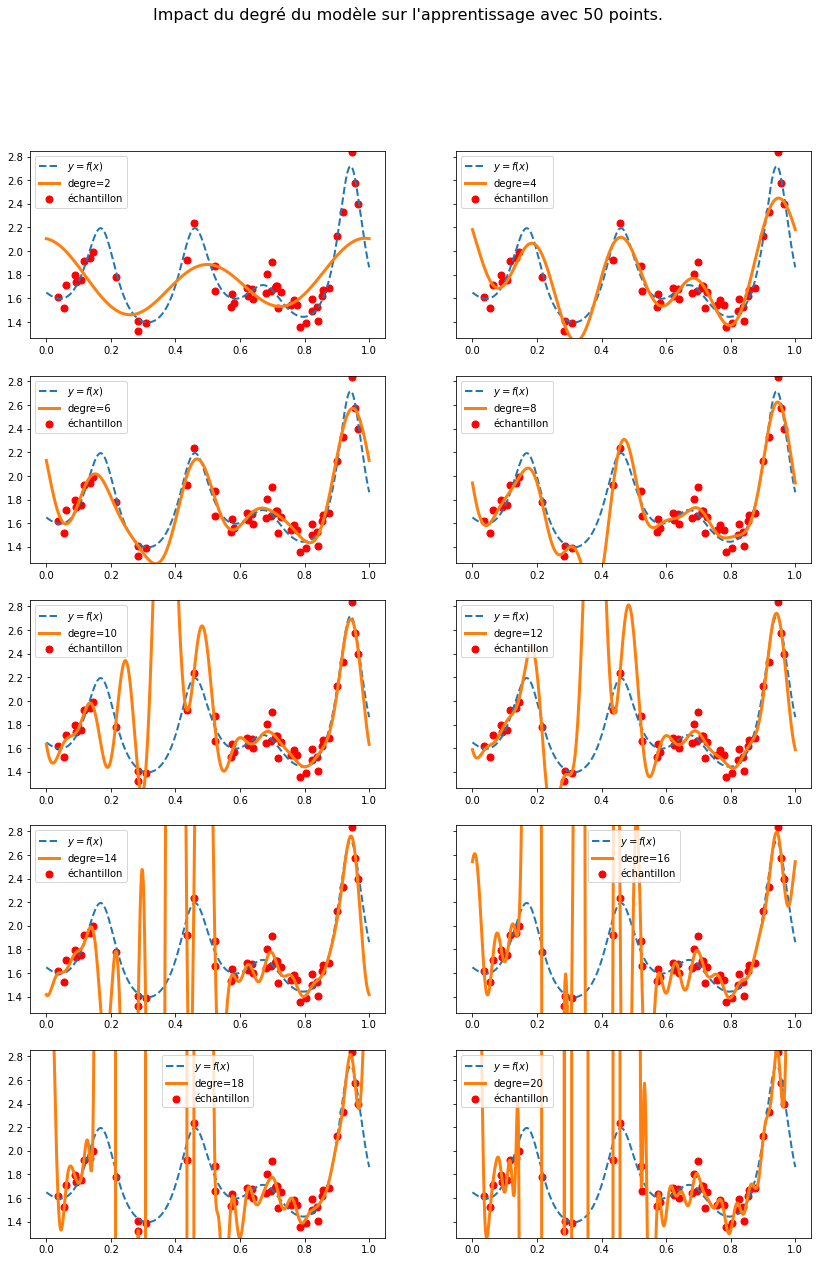

In [6]:
degres = [2 * d for d in range(1, 11)]
fig, reps = plt.subplots(nrows=5, ncols=2, sharey=True, figsize=(14, 20))

fig.suptitle(
    "Impact du degré du modèle sur l'apprentissage avec " 
    f"{len(echantillon.abcisses)} points.",
    fontsize=16
)
for degre, rep in zip(degres, reps.flatten()):
    cible.affichage(rep)
    echantillon.affichage(rep)
    modele = lib.ModeleTrigonometrique(
        degre=degre, 
        gauche=cible.gauche, 
        droite=cible.droite
    )
    modele.entraine(echantillon)
    modele.affichage(cible=cible, repere=rep)
    rep.set_ylim(cible.min, cible.max)
    rep.legend()

# Utilisation de `train_test_split`

In [7]:
def etude_degres(choix_points, choix_bruit, mod):
    echantillon = lib.genere_echantillon(
        cible=cible, 
        nb_points=50, 
        choix_points=choix_points, 
        choix_bruit=choix_bruit, 
        amplitude=0.1
    )
    train, test = lib.train_test_split(
        echantillon, 
        proba_train=0.7,
    )
    degres = [d for d in range(1, 30)]
    erreurs_objective = list()
    erreurs_train = list()
    erreurs_test = list()
    for degre in degres:
        modele = mod(degre)
        modele.entraine(train)
        erreurs_objective.append(lib.erreur_objective(modele, cible))
        erreurs_train.append(lib.erreur_empirique(modele, train))
        erreurs_test.append(lib.erreur_empirique(modele, test))
    return degres, erreurs_objective, erreurs_train, erreurs_test
    

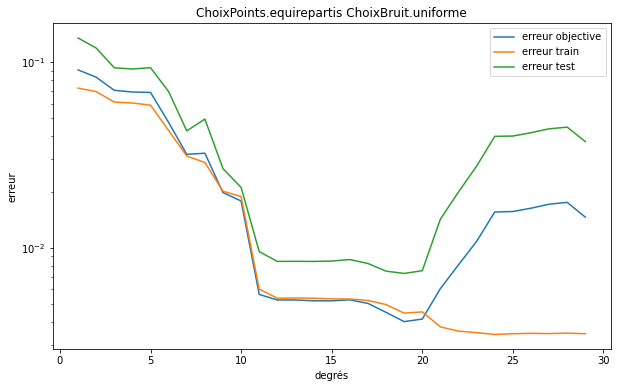

In [8]:
fig, rep = plt.subplots(figsize=(10, 6))
choix_bruit = lib.ChoixBruit.uniforme
choix_points = lib.ChoixPoints.equirepartis
degres, erreurs_objective, erreurs_train, erreurs_test = etude_degres(
    choix_bruit=choix_bruit, 
    choix_points=choix_points,
    mod=lib.ModelePolynomial,
)
rep.set_title(f"{choix_points} {choix_bruit}")
rep.set_xlabel("degrés")
rep.set_ylabel("erreur")
rep.semilogy(degres, erreurs_objective, label="erreur objective")
rep.semilogy(degres, erreurs_train, label="erreur train")
rep.semilogy(degres, erreurs_test, label="erreur test")
rep.legend()

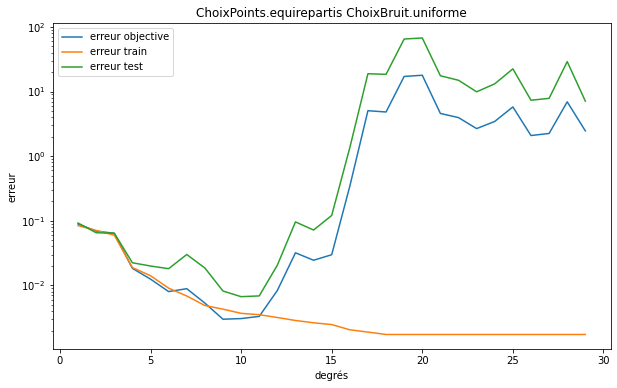

In [9]:
fig, rep = plt.subplots(figsize=(10, 6))
choix_bruit = lib.ChoixBruit.uniforme
choix_points = lib.ChoixPoints.equirepartis
degres, erreurs_objective, erreurs_train, erreurs_test = etude_degres(
    choix_bruit=choix_bruit, 
    choix_points=choix_points,
    mod=lambda deg: lib.ModeleTrigonometrique(deg, 0., 1.),
)
rep.set_title(f"{choix_points} {choix_bruit}")
rep.set_xlabel("degrés")
rep.set_ylabel("erreur")
rep.semilogy(degres, erreurs_objective, label="erreur objective")
rep.semilogy(degres, erreurs_train, label="erreur train")
rep.semilogy(degres, erreurs_test, label="erreur test")
rep.legend()

**Conclusion** on voit que l'erreur empirique sur la partie de test suit bien le même comportement que l'erreur objective.
La méthodologie permet donc de détecter le surapprentissage dans ce cas.

# Utilisation de `cross-validation`

In [10]:
echantillon = lib.genere_echantillon(
    cible=cible, 
    nb_points=100, 
    choix_points=lib.ChoixPoints.equirepartis, 
    choix_bruit=lib.ChoixBruit.uniforme, 
    amplitude=0.1
)
ech_train, ech_test = lib.train_test_split(echantillon, 0.7)

In [11]:
modeles = [lib.ModelePolynomial(degre=d) for d in range(5, 80, 7)]
modeles.extend(
    [
        lib.ModeleTrigonometrique(
            degre=d, 
            gauche=cible.gauche, 
            droite=cible.droite
        )
        for d in range(5, 45, 5)
    ]
)

In [12]:
meilleur = lib.cross_validation(echantillon=ech_train, modeles=modeles)


In [13]:
print(
    f"""meilleur modèle {meilleur!r}
erreur d'entrainement {lib.erreur_empirique(modele=meilleur, echantillon=ech_train)}
erreur de test        {lib.erreur_empirique(modele=meilleur, echantillon=ech_test)}
"""
)

meilleur modèle self.ModelePolynomial(degre=19)
erreur d'entrainement 0.0044676908266856165
erreur de test        0.007212466399264804



**Conclusion** à ce stade on a choisit notre modèle candidat par cross validation.
On constate que l'erreur bien que plus grande sur la partie de test est comparable.
On peut donc raisonnablement espérer ne pas être en surapprentissage.

A titre de vérification (mais c'est **interdit** par la méthodologie) on peut regarder les erreurs des deux types sur les autres modèles et constater qu'il y a des modèles comparables mais aucun de radicalement meilleur (on en voit par contre certains en plein surapprentissage).

In [14]:
for modele in modeles:
    modele.entraine(ech_train)
    print(
    f"""modèle {modele!r}
erreur d'entrainement {lib.erreur_empirique(modele=modele, echantillon=ech_train)}
erreur de test        {lib.erreur_empirique(modele=modele, echantillon=ech_test)}
"""
)

modèle self.ModelePolynomial(degre=5)
erreur d'entrainement 0.06296400482494752
erreur de test        0.06409785079562239

modèle self.ModelePolynomial(degre=12)
erreur d'entrainement 0.005315060344192008
erreur de test        0.010601744814724052

modèle self.ModelePolynomial(degre=19)
erreur d'entrainement 0.0044676908266856165
erreur de test        0.007212466399264804

modèle self.ModelePolynomial(degre=26)
erreur d'entrainement 0.004177508871940584
erreur de test        0.006388713699734275

modèle self.ModelePolynomial(degre=33)
erreur d'entrainement 0.004059194516860808
erreur de test        0.005969527620808394

modèle self.ModelePolynomial(degre=40)
erreur d'entrainement 0.004012024643482784
erreur de test        0.005980741092697693

modèle self.ModelePolynomial(degre=47)
erreur d'entrainement 0.003942823027709039
erreur de test        0.006097154050789177

modèle self.ModelePolynomial(degre=54)
erreur d'entrainement 0.003908319370113497
erreur de test        0.00628238535423